# Handling Missing Response

Because of the generative nature of the exponential smoothing models, they can naturally deal with missing response during the training process. It simply replaces observations by prediction during the 1-step ahead generating process. Below users can find the simple examples of how those exponential smoothing models handle missing responses.

In [1]:
import pandas as pd
import numpy as np
import orbit
import matplotlib.pyplot as plt

from orbit.utils.dataset import load_iclaims
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.plot import get_orbit_style
from orbit.models import ETS, LGT, DLT
from orbit.diagnostics.metrics import smape

plt.style.use(get_orbit_style())

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
orbit.__version__

'1.1.1dev'

## Data

In [3]:
# can also consider transform=False
raw_df = load_iclaims(transform=True)
raw_df.dtypes

df = raw_df.copy()
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [4]:
test_size=52

train_df=df[:-test_size]
test_df=df[-test_size:]

### Define Missing Data
Now, we manually created a dataset with a few missing values in the response variable.

In [5]:
na_idx = np.arange(53, 100, 1)
na_idx

array([53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [6]:
train_df_na = train_df.copy()
train_df_na.iloc[na_idx, 1] = np.nan

## Exponential Smoothing Examples

### ETS

In [7]:
ets = ETS(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=2022,
    estimator='stan-mcmc'
)
ets.fit(train_df_na)
ets_predicted = ets.predict(df=train_df_na)

### LGT

In [8]:
lgt = LGT(
    response_col='claims', 
    date_col='week',
    estimator='stan-mcmc', 
    seasonality=52,
    seed=2022
)
lgt.fit(df=train_df_na)
lgt_predicted = lgt.predict(df=train_df_na)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### DLT

In [9]:
dlt = DLT(
    response_col='claims',
    date_col='week',
    estimator='stan-mcmc',
    seasonality=52,
    seed=2022
)
dlt.fit(df=train_df_na)
dlt_predicted = dlt.predict(df=train_df_na)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Summary

Users can verify this behavior with a table and visualziation of the actuals and predicted.

In [10]:
train_df_na['ets-predict'] = ets_predicted['prediction']
train_df_na['lgt-predict'] = lgt_predicted['prediction']
train_df_na['dlt-predict'] = dlt_predicted['prediction']

In [11]:
# table summary of prediction during absence of observations
train_df_na.iloc[na_idx, :].head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix,ets-predict,lgt-predict,dlt-predict
53,2011-01-09,NaN,0.152060,-0.127397,0.085412,-0.295869,-0.036658,13.516891,13.502820,13.514451
54,2011-01-16,NaN,0.186546,-0.044015,0.074483,-0.303546,0.141233,13.269185,13.287483,13.281159
55,2011-01-23,NaN,0.169451,-0.004795,0.074483,-0.309024,0.222816,13.009352,13.007293,13.015555
56,2011-01-30,NaN,0.079300,0.032946,-0.005560,-0.282329,-0.006710,13.044864,13.072037,13.070768
57,2011-02-06,NaN,0.060252,-0.024213,0.006275,-0.268480,-0.021891,12.989848,13.008208,13.005283


In [12]:
from orbit.constants.palette import OrbitPalette

# just to get some color from orbit palette
orbit_palette = [
    OrbitPalette.BLACK.value,
    OrbitPalette.BLUE.value, 
    OrbitPalette.GREEN.value, 
    OrbitPalette.YELLOW.value,
]

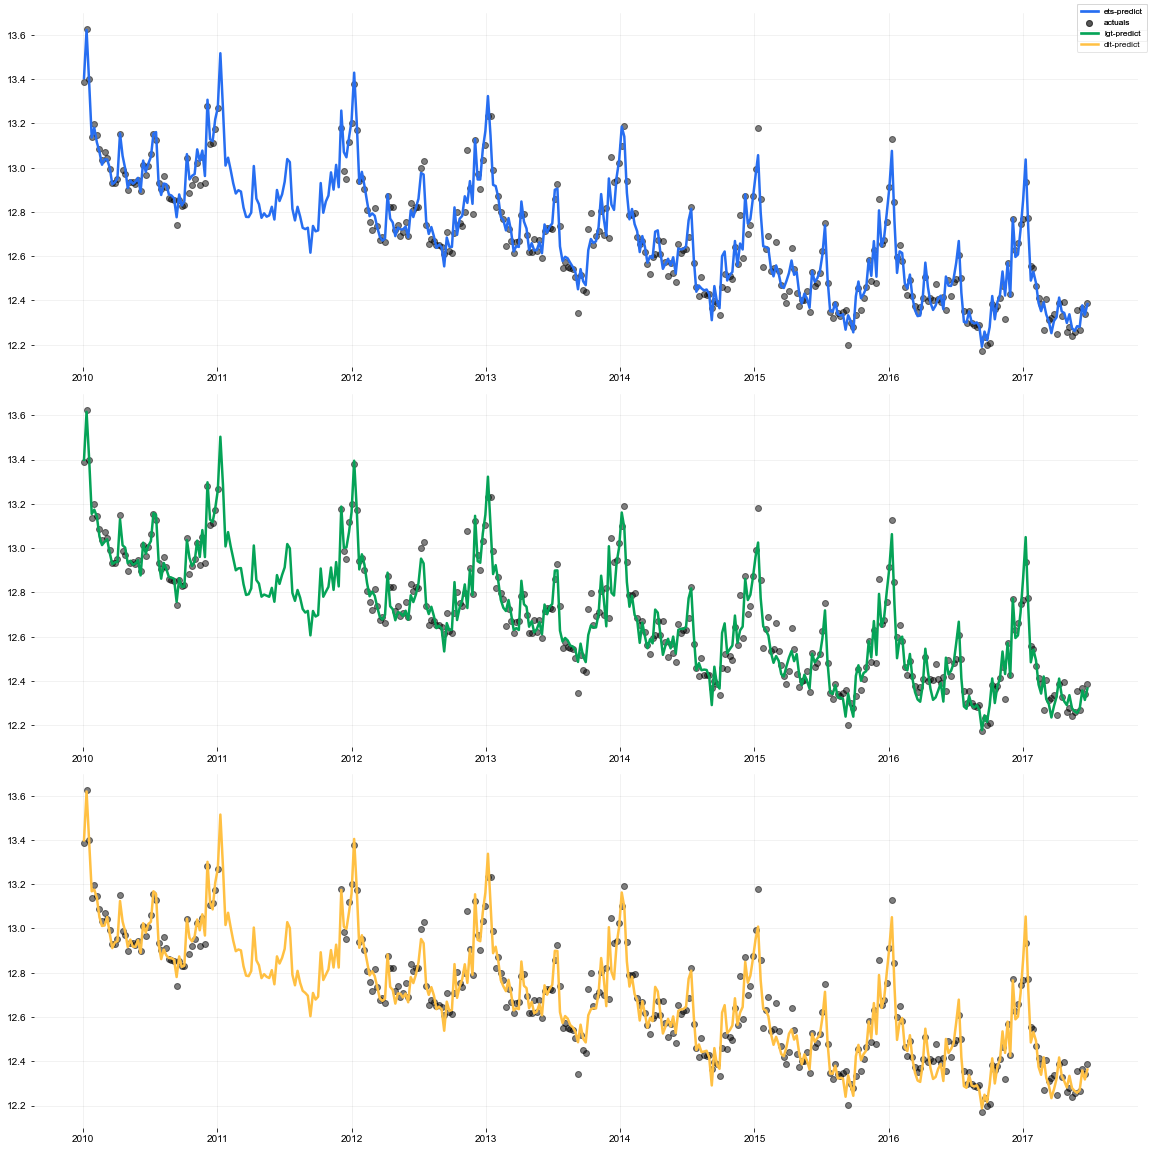

In [13]:
pred_list = ['ets-predict', 'lgt-predict', 'dlt-predict']
fig, axes = plt.subplots(len(pred_list), 1, figsize=(16, 16))
for idx, p in enumerate(pred_list):
    axes[idx].scatter(train_df_na['week'], train_df_na['claims'].values, 
                      label='actuals' if idx == 0 else '', color=orbit_palette[0], alpha=0.5)
    axes[idx].plot(train_df_na['week'], train_df_na[p].values, 
                   label=p, color=orbit_palette[idx + 1], lw=2.5)
    fig.legend()
    fig.tight_layout()

## First Observation Exception

It is worth pointing out that the very first value of the response variable cannot be missing since this is the starting point of the time series fitting. **An error message will be raised when the first observation in response is missing.**

In [14]:
na_idx2 = list(na_idx) + [0]
train_df_na2 = train_df.copy()
train_df_na2.iloc[na_idx2, 1] = np.nan
ets.fit(train_df_na2)

DataInputException: The first value of response column claims cannot be missing..